In [1]:
!pip install eli5

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats.stats import kendalltau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import activations
sns.set()

In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *

train_values = np.empty(shape=[0, 222])
test_values = np.empty(shape=[0, 222])

train_sampled_all = glob.glob('./drive/MyDrive/compsci/train_sampled_all_220.csv')
# test_sampled_all = glob.glob('./drive/MyDrive/compsci/test_sampled_all_centered_220.csv')
test_unsampled_all = glob.glob('./drive/MyDrive/compsci/test_unsampled_all_220.csv')

for j in train_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)
    
# for j in test_all:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     test_values = np.append(test_values, csvrows, axis=0)

for j in test_unsampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

Loading  ./drive/MyDrive/compsci/train_sampled_all_220.csv
Loading  ./drive/MyDrive/compsci/test_unsampled_all_220.csv
(31912, 222)
(37863, 222)


In [4]:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train_gc = (y_train - y_train.min())/(y_train.max()-y_train.min())*(9-1)
y_test_gc = (y_test - y_test.min())/(y_test.max()-y_test.min())*(9-1)

In [5]:
#use this for all data training and testing

# X_train1 = X_train.reshape(X_train.shape + (1,1))
# X_test1 = X_test.reshape(X_test.shape + (1,1))

# y_train1=to_categorical(y_train)
# y_test1=to_categorical(y_test)

In [6]:
#use this for per class testing

class_num = 1

N_train = train_values
N_test = test_values[test_values[:,-2]==class_num]
print(N_train.shape)
print(N_test.shape)

X_train = N_train[:,:-2]
X_test = N_test[:,:-2]

# y_train = train_values[:len(N_train),-2]
# y_test = test_values[:len(N_test),-2]

y_train = N_train[:len(N_train),-2]
y_test = N_test[:len(N_test),-2]

X_train1 = X_train.reshape(X_train.shape + (1,1,))
X_test1 = X_test.reshape(X_test.shape + (1,1,))


y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

(31912, 222)
(28703, 222)


In [37]:
#Use this for noisy test data
s = np.random.normal(0, 0.5, X_test.shape)
noise_test = X_test+s
print(noise_test.shape)
X_test1 = noise_test.reshape(noise_test.shape + (1,1))

(28703, 220)


In [38]:
def showResults(test, pred):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred)
    print(cm)
    return cm

In [39]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 5, 64
activationFunction='relu'

def getModel():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train1.shape[1],1)))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(512, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 220, 128)          2176      
_________________________________________________________________
batch_normalization_4 (Batch (None, 220, 128)          512       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 220, 32)           65568     
_________________________________________________________________
batch_normalization_5 (Batch (None, 220, 32)           128       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 220, 9)            4617      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 110, 9)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 990)              

In [40]:
modelhistory= cnnmodel.fit(X_train1[:,:,:,0], y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Train on 25529 samples, validate on 6383 samples
Epoch 1/5
25472/25529 [============================>.] - ETA: 0s - loss: 0.3415 - accuracy: 0.8905

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 4s 146us/sample - loss: 0.3412 - accuracy: 0.8906 - val_loss: 0.3502 - val_accuracy: 0.8911
Epoch 2/5
25529/25529 [==============================] - 3s 132us/sample - loss: 0.1252 - accuracy: 0.9580 - val_loss: 0.1145 - val_accuracy: 0.9641
Epoch 3/5
25529/25529 [==============================] - 3s 134us/sample - loss: 0.0860 - accuracy: 0.9711 - val_loss: 0.0985 - val_accuracy: 0.9695
Epoch 4/5
25529/25529 [==============================] - 3s 134us/sample - loss: 0.0654 - accuracy: 0.9767 - val_loss: 0.0886 - val_accuracy: 0.9745
Epoch 5/5
25529/25529 [==============================] - 3s 133us/sample - loss: 0.0498 - accuracy: 0.9831 - val_loss: 0.1048 - val_accuracy: 0.9705


In [41]:
############## Get CAM ################
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

get_last_conv1 = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[4].output])
last_conv1_cnn = get_last_conv1([X_test1[:,:,:,0]])[0]

get_softmax1_cnn = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[-1].output])
softmax1_cnn = get_softmax1_cnn(([X_test1[:,:,:,0]]))[0]
softmax_weight1_cnn = cnnmodel.get_weights()[-1]
softmax_weight_cnn = np.reshape(softmax_weight1_cnn,(9,1))

CAM = np.dot(last_conv1_cnn, softmax_weight_cnn)

# for k in range(1):
#     CAM_cnn = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
#     c = np.exp(CAM_cnn) / np.sum(np.exp(CAM_cnn), axis=1, keepdims=True)
#     plt.figure(figsize=(18, 4))
#     plt.plot(X_test1[k].squeeze())
#     plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
#     # plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
#     plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
#     plt.clim(0.003,0.010)
#     plt.colorbar()
# plt.show

In [42]:
cnnpredictions = cnnmodel.predict(X_test1[:,:,:,0], verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy  : 0.8298435703584991
Precision : 1.0
f1Score : 0.9070103956437303
[[23819    62    13  1094  2948   354   407     6]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]]
              precision    recall  f1-score   support

           1      1.000     0.830     0.907     28703
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0

    accuracy               

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


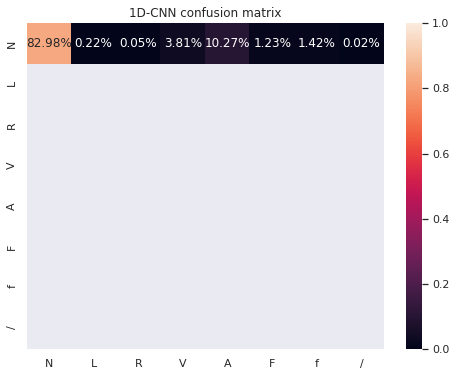

In [43]:
#performance metrics

cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(y_test1,axis=1)
CNN_cf_m = showResults(cnn_actual_value, cnn_predict)
from sklearn import metrics
cnnmetrics = metrics.classification_report(cnn_actual_value, cnn_predict, digits=3)
print(cnnmetrics, 'CNN metrics')
categories=['N','L','R','V','A','F','f','/']
plt.figure(figsize=(8,6))
CNN_cf_m = CNN_cf_m.astype('float')/ CNN_cf_m.sum(axis=1)[:,np.newaxis]
sns.heatmap(CNN_cf_m,annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1)
plt.title('1D-CNN confusion matrix')
plt.show()

In [44]:
from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = last_conv1_cnn
new_last_conv1 = []

for i in range(len(last_conv1_cnn)):
  means = list(means_of_slices(a[i], 20))
  new_last_conv1.append(means)
new_last_conv1 = np.array(new_last_conv1)
print(new_last_conv1.shape)

final_last_conv1 = []
for i in new_last_conv1:
  final_last_conv1.append(np.repeat(i,20))
final_last_conv1 = np.array(final_last_conv1)
print(final_last_conv1.shape)

(28703, 11)
(28703, 220)


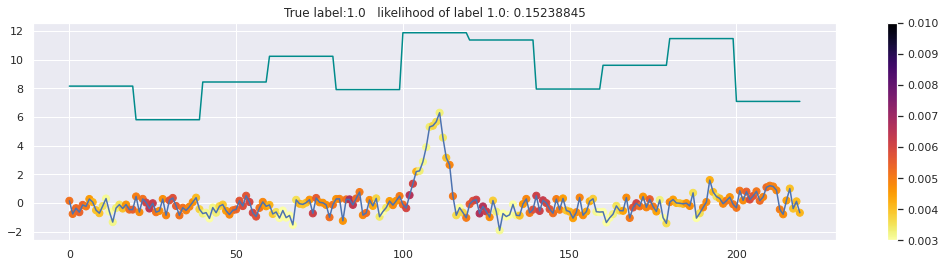

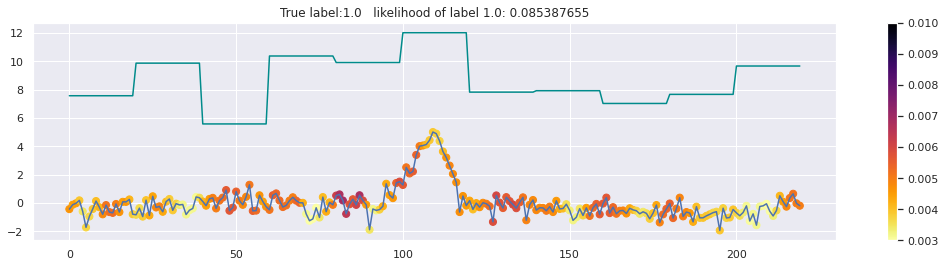

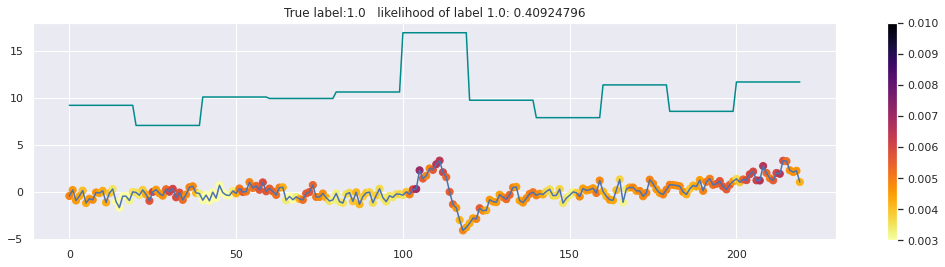

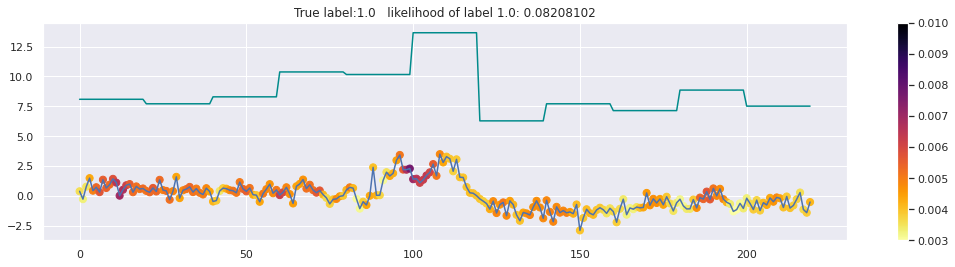

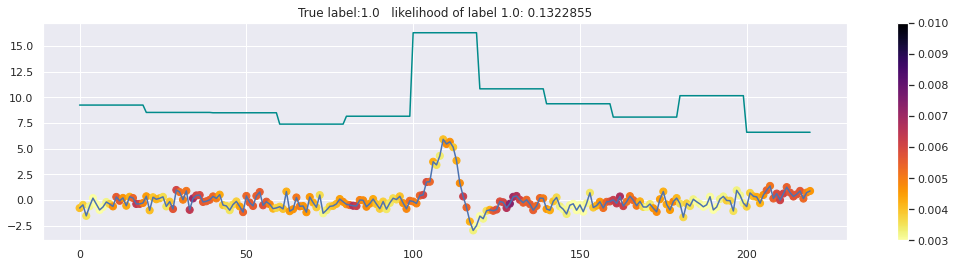

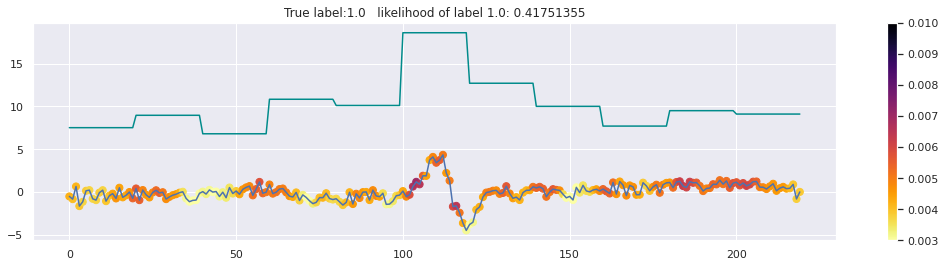

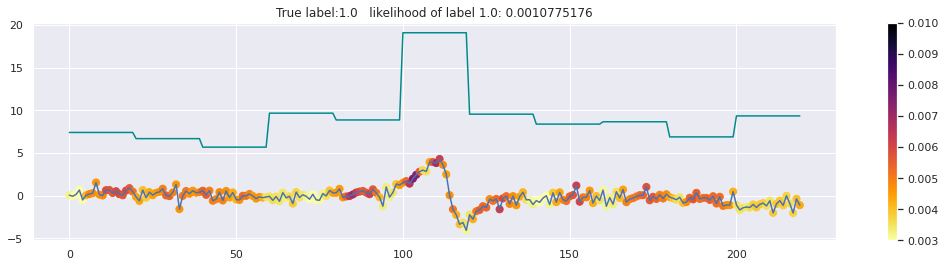

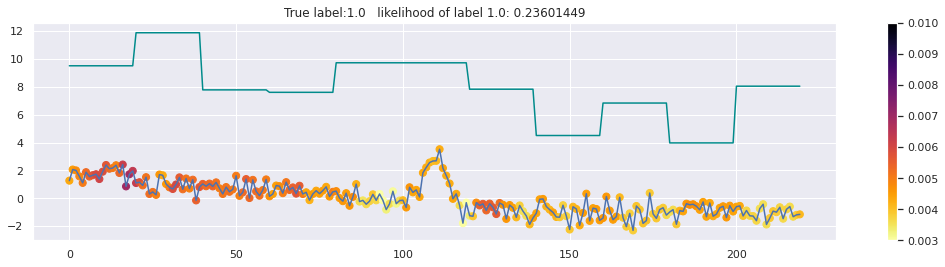

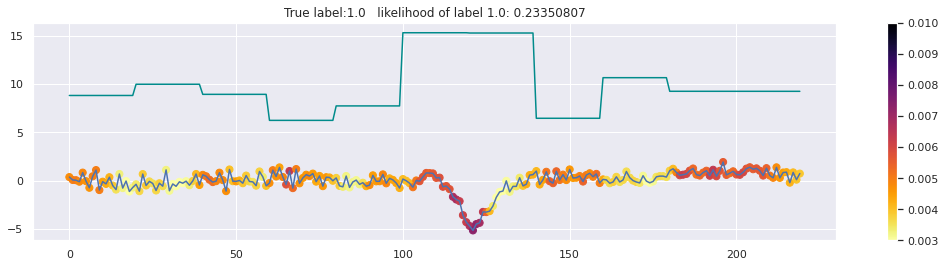

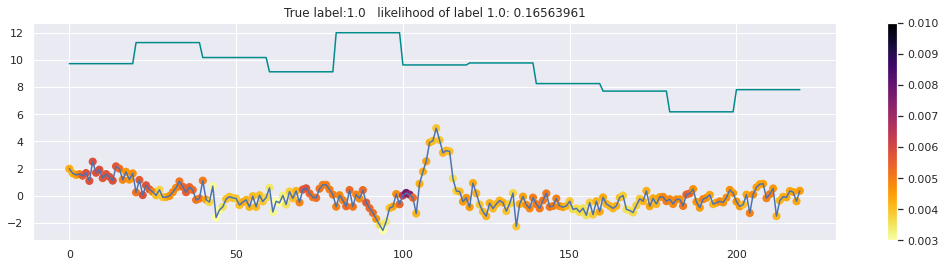

In [45]:
#misclassified saliency
misclass_cnn = np.where(cnn_predict!=cnn_actual_value)
misclass_cnn = misclass_cnn[0].tolist()

for i in misclass_cnn[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_conv1[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

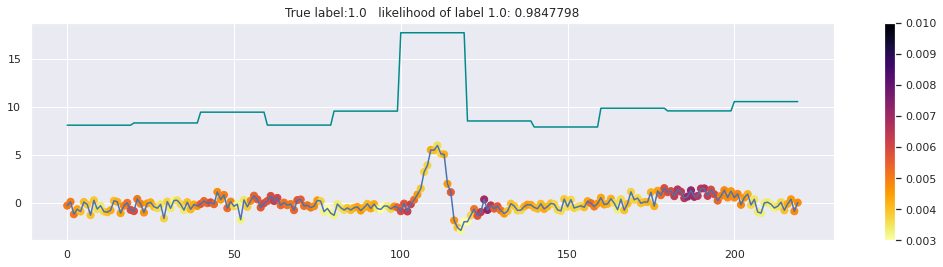

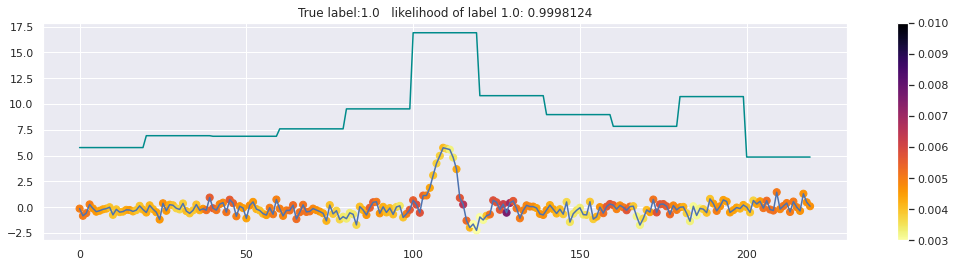

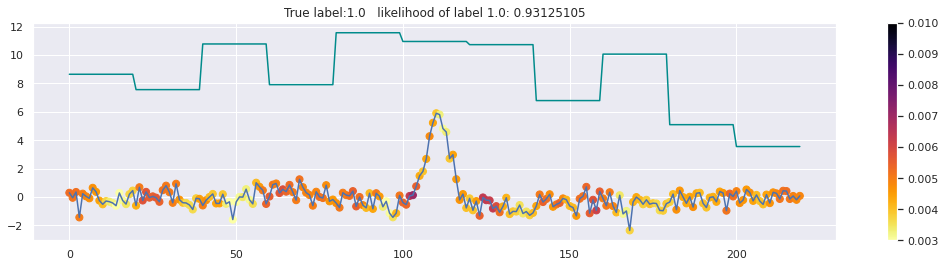

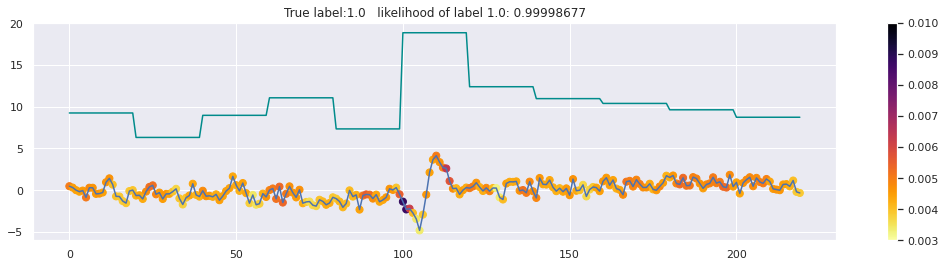

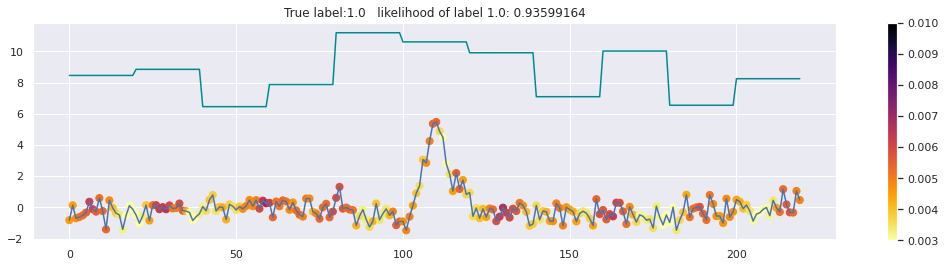

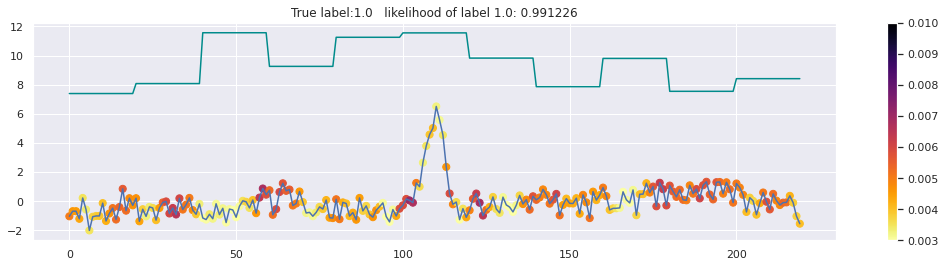

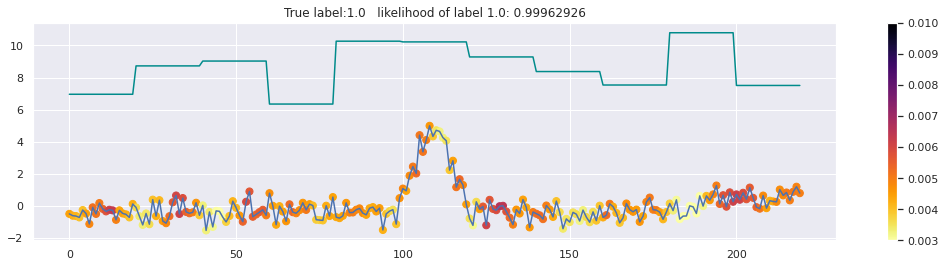

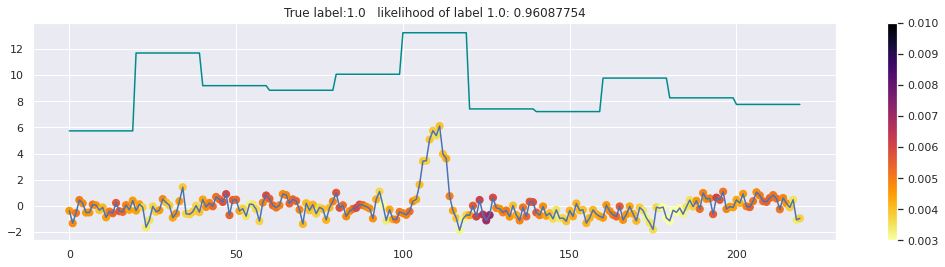

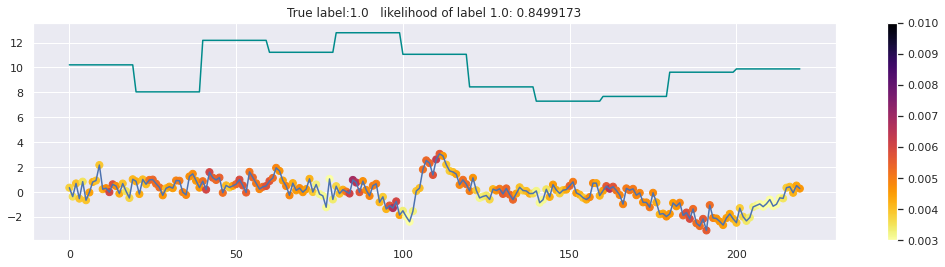

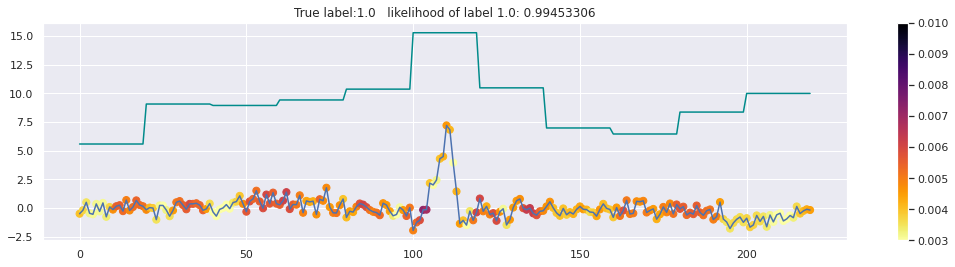

In [46]:
#correct saliency
correct_cnn = np.where(cnn_predict==cnn_actual_value)
correct_cnn = correct_cnn[0].tolist()

for i in correct_cnn[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_conv1[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

In [47]:
#permutation feature weights

import eli5
from eli5 import format_as_image
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier
NNMLP_clf = MLPClassifier(random_state=48, max_iter=50)
NNMLP_clf.fit(new_last_conv1, y_test1[:])

perm = PermutationImportance(NNMLP_clf).fit(new_last_conv1, y_test1)
print('CNN results')
eli5.show_weights(perm)

CNN results


/usr/local/lib/python3.7/dist-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,x10
0 ± 0.0000,x9
0 ± 0.0000,x8
0 ± 0.0000,x7
0 ± 0.0000,x6
0 ± 0.0000,x5
0 ± 0.0000,x4
0 ± 0.0000,x3
0 ± 0.0000,x2
0 ± 0.0000,x1


In [48]:
perm = PermutationImportance(NNMLP_clf).fit(new_last_conv1[correct_cnn[:]], y_test1[[correct_cnn[:]]])
print('CNN Correct results')
eli5.show_weights(perm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


CNN Correct results


/usr/local/lib/python3.7/dist-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,x10
0 ± 0.0000,x9
0 ± 0.0000,x8
0 ± 0.0000,x7
0 ± 0.0000,x6
0 ± 0.0000,x5
0 ± 0.0000,x4
0 ± 0.0000,x3
0 ± 0.0000,x2
0 ± 0.0000,x1


In [49]:
perm = PermutationImportance(NNMLP_clf).fit(new_last_conv1[misclass_cnn[:]], y_test1[misclass_cnn[:]])
print('CNN Misclass results')
eli5.show_weights(perm)

CNN Misclass results


/usr/local/lib/python3.7/dist-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,x10
0 ± 0.0000,x9
0 ± 0.0000,x8
0 ± 0.0000,x7
0 ± 0.0000,x6
0 ± 0.0000,x5
0 ± 0.0000,x4
0 ± 0.0000,x3
0 ± 0.0000,x2
0 ± 0.0000,x1


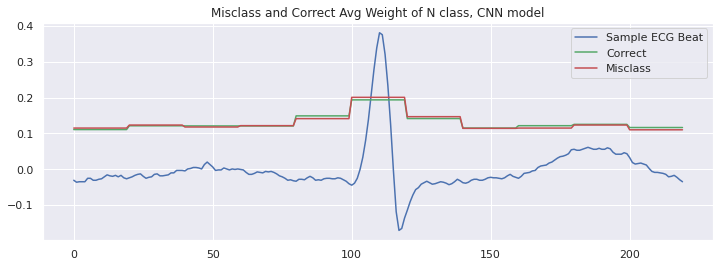

In [50]:
from sklearn.preprocessing import normalize

n0= normalize(final_last_conv1[correct_cnn[:]])
n1= normalize(final_last_conv1[misclass_cnn[:]])
n2= normalize(X_test)

m0=n0.mean(axis=0)
m1=n1.mean(axis=0)

plt.figure(figsize=(12,4))
plt.plot(n2[0],color='b',label='Sample ECG Beat')
plt.plot(m0*2,color='g',label='Correct')
plt.plot(m1*2,color='r',label='Misclass')
plt.title('Class: N, Number: ' + str(class_num))
plt.title('Misclass and Correct Avg Weight of N class, CNN model')
# plt.title('Misclass and Correct Avg Weight of all beats, CNN model')
plt.legend()
plt.show()

In [51]:
# # saving the model

# model_json = cnnmodel.to_json()
# with open("NEWcnnmodel_testunsam.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# cnnmodel.save_weights("NEWcnnmodel_testunsam_weights.h5")
# cnnmodel.save("NEWcnnmodel_testunsam.h5")
# print("Saved model to disk")